## Problem 1b

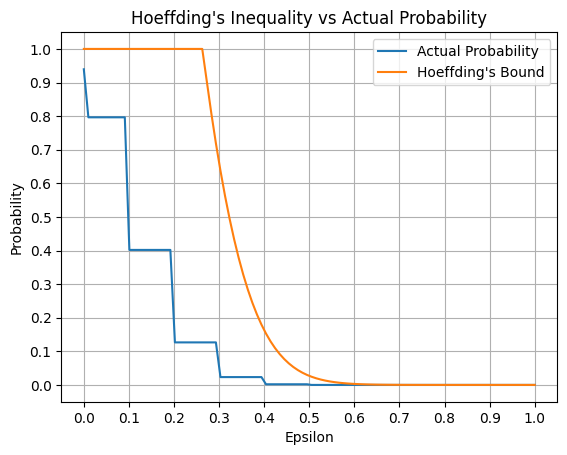

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math

def factorial(n):
    # Base case: if n is 0 or 1, the factorial is 1
    if n == 0 or n == 1:
        return 1
    # Recursive case: compute factorial using recursion
    else:
        return n * factorial(n - 1)

# Calculate the binomial probability of k for n tosses and p probability
def binomial_pmf(n, p, k):
    pmf = (factorial(n) / (factorial(k) * factorial(n - k))) * p ** k * (1 - p) ** (n - k)
    return pmf

def bernoulli_cdf(left_bound, right_bound, n, p):
    cdf_p = 0.0
    for i in range(left_bound, right_bound+1, 1):
        cdf_p += binomial_pmf(n, p, i)
    return cdf_p

def hoeffding_bound(n, m, epsilon):
    bound = 2 * m * np.exp(-2 * n * epsilon**2)
    if bound > 1:
        bound = 1
    return bound


def actual_probability(p, n, epsilon):
    if epsilon > 0.5:
        return 0.0
    else:
        return 1 - bernoulli_cdf(int(n * p - n * epsilon), int(n * p + n * epsilon), n, p) ** 2

def plot_hoeffding_vs_actual(p, n):
    epsilons = np.linspace(0, 1, 100)
    actual_probs = [actual_probability(p, n, epsilon) for epsilon in epsilons]
    hoeffding_probs = [hoeffding_bound(n, 2, epsilon) for epsilon in epsilons]

    plt.plot(epsilons, actual_probs, label='Actual Probability')
    plt.plot(epsilons, hoeffding_probs, label="Hoeffding's Bound")
    plt.xlabel('Epsilon')
    plt.ylabel('Probability')
    plt.title("Hoeffding's Inequality vs Actual Probability")

    num_ticks = 10
    tick_positions = [i/10 for i in range(0, 11, 1)]
    tick_labels = ['{}'.format(i/10) for i in range(0, num_ticks + 1)]
    plt.xticks(tick_positions, tick_labels)
    plt.yticks(tick_positions, tick_labels)
    # Add a grid
    plt.grid(True)
    plt.legend()
    plt.show()

# Parameters
p = 0.5  # Probability of heads for each coin
n = 10   # Number of tosses

# Plotting
plot_hoeffding_vs_actual(p, n)

## Problem 3a

Text(0.5, 1.0, 'Conditional probability of P(X|Y=0) and P(X|Y=1)')

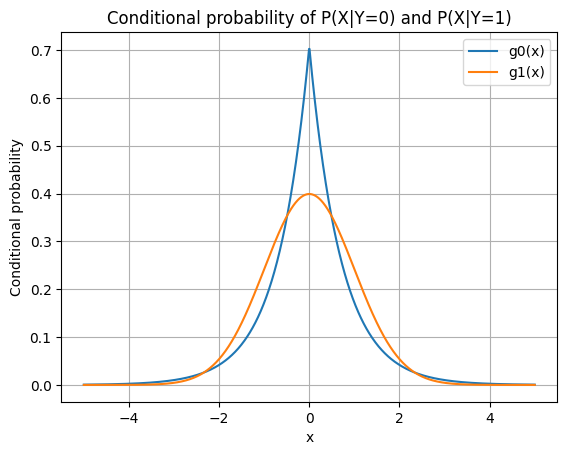

In [12]:
def g0(x):
    return 1/math.sqrt(2)*np.exp(-math.sqrt(2)*abs(x));

def g1(x):
    return 1/math.sqrt(2*(math.pi))*np.exp((-x**2)/2);

x_value=np.linspace(-5,5,1000);
g0_value=[g0(x) for x in x_value];
g1_value=[g1(x) for x in x_value];

plt.plot(x_value,g0_value,label='g0(x)');
plt.plot(x_value,g1_value,label='g1(x)');
plt.legend()
plt.xlabel('x')
plt.ylabel('Conditional probability')
plt.grid()
plt.title("Conditional probability of P(X|Y=0) and P(X|Y=1)")

## Problem 4

## 1. Define functions

In [2]:
import numpy as np
import random
from scipy.io import loadmat

def load_data(file_name):
    mat_data = loadmat(f'dataLDA/{file_name}.mat')

    x_array = mat_data['X']
    y_array = mat_data['Y']

    x_numpy_array = np.array(x_array)
    y_numpy_array = np.array(y_array)
    return x_numpy_array, y_numpy_array

def load_data_5d(file_name, x_key, y_key):
    mat_data = loadmat(f'dataLDA/{file_name}.mat')

    x_array = mat_data[x_key]
    y_array = mat_data[y_key]

    x_numpy_array = np.array(x_array)
    y_numpy_array = np.array(y_array)
    return x_numpy_array, y_numpy_array

def calc_pi_k(training_x, training_y):
    d = training_x.shape[0]
    n = training_x.shape[1]
    unique_values = np.unique(training_y)
    k = len(unique_values)

    pi_k = np.zeros(k)
    for i in range(k):
        pi_k[i] = np.sum([training_y[0] == i])/n
    return pi_k

def calc_miu_k(training_x, training_y):
    d = training_x.shape[0]
    n = training_x.shape[1]
    unique_values = np.unique(training_y)
    k = len(unique_values)

    miu_k = np.zeros((d,k))
    for i in range(k):
        training_x_is_i = training_x[:,training_y[0] == i]
        miu_k[:,i] = np.sum(training_x_is_i,axis=1)/np.sum([training_y == i])

    return miu_k

def calc_sigma(training_x, training_y, miu_k):
    d = training_x.shape[0]
    n = training_x.shape[1]
    unique_values = np.unique(training_y)
    k = len(unique_values)

    sigma = np.zeros((d,d))
    for i in range(k):
        training_x_is_i = training_x[:,training_y[0] == i]
        for j in range(training_x_is_i.shape[1]):
            sigma += np.outer(training_x_is_i[:,j] - miu_k[:,i],training_x_is_i[:,j] - miu_k[:,i])
    sigma = sigma/n
    return sigma

def calc_sigma_simple(sigma,d):
    sigma_square = np.trace(sigma)/d
    sigma_simple = sigma_square*np.eye(d)
    return sigma_simple

def calc_a_b(sigma,miu_k, pi_k):
    a = np.linalg.inv(sigma) @ (miu_k[:,1]-miu_k[:,0])
    b = -0.5*miu_k[:,1].T @ np.linalg.inv(sigma) @ miu_k[:,1] + 0.5*miu_k[:,0].T @ np.linalg.inv(sigma) @ miu_k[:,0] + np.log(pi_k[0]/pi_k[1])
    return a,b

def classifier(a,b,x):
    value = a.T @ x + b
    if value >= 0:
        return 1
    else:
        return 0

## 2. Validate synthetic data

In [50]:
file_names = np.array(['synthetic1','synthetic2','synthetic3','synthetic4'])
for file_name in file_names:

    training_x, training_y = load_data(file_name)
    d = training_x.shape[0]
    n = training_x.shape[1]
    unique_values = np.unique(training_y)
    k = len(unique_values)

    pi_k = calc_pi_k(training_x, training_y)
    miu_k = calc_miu_k(training_x, training_y)
    sigma = calc_sigma(training_x, training_y, miu_k)
    sigma_simple = calc_sigma_simple(sigma,d)
    a,b = calc_a_b(sigma,miu_k, pi_k)
    a_simple, b_simple = calc_a_b(sigma_simple,miu_k, pi_k)

    training_y_hat = np.zeros((1,n))
    training_y_hat_simple = np.zeros((1,n))
    for i in range(n):
        value = a.T @ training_x[:,i] + b
        training_y_hat[0,i] = classifier(a,b,training_x[:,i])
        training_y_hat_simple[0,i] = classifier(a_simple,b_simple,training_x[:,i])

    risk = np.sum(training_y_hat[0] != training_y[0])/n
    risk_simple = np.sum(training_y_hat_simple[0] != training_y[0])/n

    print('---------------------------------------------------------')
    print(file_name)
    print('a = ',a)
    print('b = ',b)
    print('sigma =\n',sigma)
    print('sigma_simple =\n',sigma_simple)
    print('risk:',risk,',risk_simple:',risk_simple)


---------------------------------------------------------
synthetic1
a =  [25.79723763 27.17261469]
b =  -25.78410886820642
sigma =
 [[0.03780866 0.00115064]
 [0.00115064 0.0371704 ]]
sigma_simple =
 [[0.03748953 0.        ]
 [0.         0.03748953]]
risk: 0.0 ,risk_simple: 0.0
---------------------------------------------------------
synthetic2
a =  [ 9.39193027 20.19938674]
b =  -14.453993274326724
sigma =
 [[0.06990821 0.01541904]
 [0.01541904 0.04335511]]
sigma_simple =
 [[0.05663166 0.        ]
 [0.         0.05663166]]
risk: 0.015 ,risk_simple: 0.01
---------------------------------------------------------
synthetic3
a =  [0.67001069 2.89413401]
b =  -1.800296710549185
sigma =
 [[ 1.87364691 -0.14718935]
 [-0.14718935  0.3848668 ]]
sigma_simple =
 [[1.12925686 0.        ]
 [0.         1.12925686]]
risk: 0.18 ,risk_simple: 0.21
---------------------------------------------------------
synthetic4
a =  [3.43030007 3.29444822]
b =  -3.2297169527803327
sigma =
 [[ 0.2572706  -0.071747

## 5d

In [9]:
training_x, training_y = load_data_5d('trainTrain', 'Xtrain', 'Ytrain')
d = training_x.shape[0]
n = training_x.shape[1]
unique_values = np.unique(training_y)
k = len(unique_values)

pi_k = calc_pi_k(training_x, training_y)
miu_k = calc_miu_k(training_x, training_y)
sigma = calc_sigma(training_x, training_y, miu_k)
sigma_simple = calc_sigma_simple(sigma,d)
a,b = calc_a_b(sigma,miu_k, pi_k)
a_simple, b_simple = calc_a_b(sigma_simple,miu_k, pi_k)

training_y_hat = np.zeros((1,n))
training_y_hat_simple = np.zeros((1,n))
for i in range(n):
    training_y_hat[0,i] = classifier(a,b,training_x[:,i])
    training_y_hat_simple[0,i] = classifier(a_simple,b_simple,training_x[:,i])

risk = np.sum(training_y_hat[0] != training_y[0])/n
risk_simple = np.sum(training_y_hat_simple[0] != training_y[0])/n

print('---------------------------------------------------------')
print('trainTrain')
print('n = ',n,' k = ',k,' d = ',d)
print('pi_k =\n',pi_k)
print('miu_k =\n',miu_k)
print('sigma =\n',sigma)
print('sigma_simple =\n',sigma_simple)
print('a = ',a)
print('b = ',b)
print('risk:',risk,',risk_simple:',risk_simple)

---------------------------------------------------------
trainTrain
n =  231  k =  2  d =  9
pi_k =
 [0.63636364 0.36363636]
miu_k =
 [[133.48979592 138.69047619]
 [  2.65802721   5.54892857]
 [  4.48707483   5.54261905]
 [ 23.91809524  27.62821429]
 [  0.29251701   0.58333333]
 [ 53.41496599  55.98809524]
 [ 25.91442177  26.665     ]
 [ 12.23537415  19.71619048]
 [ 38.95918367  49.45238095]]
sigma =
 [[ 3.49457520e+02  1.53559488e+01  4.75293813e+00  4.86939858e+01
  -3.58850900e-01  1.03844715e+01  1.72424746e+01  2.62490650e+01
   7.58471891e+01]
 [ 1.53559488e+01  1.98373348e+01  5.34935010e-01  5.74139388e+00
  -1.43388182e-01  2.42986696e+00  1.48704516e+00  2.01192897e+01
   2.35006878e+01]
 [ 4.75293813e+00  5.34935010e-01  4.16363665e+00  6.21608777e+00
   1.67261684e-01 -2.17744353e-01  2.53340347e+00 -5.62591797e+00
   7.56403864e+00]
 [ 4.86939858e+01  5.74139388e+00  6.21608777e+00  5.58951043e+01
   5.48915172e-01 -2.49569522e+00  2.31027129e+01  2.51590924e+00
   6.2470

## Validate test data

In [8]:
test_x, test_y = load_data_5d('testLDA', 'Xtest', 'Ytest')
n = test_x.shape[1]
test_y_hat = np.zeros((1,n))
test_y_hat_simple = np.zeros((1,n))
for i in range(n):
    test_y_hat[0,i] = classifier(a,b,test_x[:,i])
    test_y_hat_simple[0,i] = classifier(a_simple,b_simple,test_x[:,i])

risk = np.sum(test_y_hat[0] != test_y[0])/n
risk_simple = np.sum(test_y_hat_simple[0] != test_y[0])/n

print('---------------------------------------------------------')
print('n = ',n)
print('testLDA')
print('risk:',risk,',risk_simple:',risk_simple)

---------------------------------------------------------
n =  231
testLDA
risk: 0.37662337662337664 ,risk_simple: 0.42857142857142855
